# Configuration Section - Important

In [1]:
colab_flag = True  # Set it true if the notebook is run on Colab
language_model ="fin_lab_bal"  # imdb | abc | fin_unlab | fin_lab_balance | fin_lab_large | fin_lab_imp2
set_labels = "bal"  # bal | large | imp2


# Importing Modules

## General Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

## For Colab

In [3]:
if colab_flag:
  
  !pip install -Uqq fastbook   
  from fastbook import * 
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My\ Drive/Colab\ Notebooks/

  root = "/content/drive/My Drive/Colab Notebooks/"

  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

else:

  root = "C:/Users/user/ML/Ironhack/GitHub/Final_Project/"

     |████████████████████████████████| 720 kB 8.9 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 49.5 MB/s 
     |████████████████████████████████| 189 kB 47.0 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 152 kB/s 
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
Tue Dec 14 18:05:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|

## Deep Learning

In [4]:
from fastai.text.all import *

# Loading Data

In [5]:
with open(f"Data/dls/dls_lm_{language_model}", "rb") as f:
    
    dls_lm = pickle.load(f)

    f.close()

    encoder = f"{language_model}_encoder"


# Building the LSTM classification model with a transfer learning approach

#Fine tuning the classifier model

### Creating the Classifier DataLoaders

In [6]:
path = Path(root + f"Data/financial/labelled/{set_labels}")

In [7]:
dls_clas = DataBlock(
                     blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
                     get_y = parent_label,
                     get_items=partial(get_text_files, folders=['train', 'test']),
                     splitter=GrandparentSplitter(valid_name='test')
                     ).dataloaders(path, path=path, bs=50, seq_len=72)

In [8]:
# Saving the classification dls

with open(f"Data/dls/dls_clas_{set_labels}", "wb") as f:

    pickle.dump(dls_clas, f)

    f.close()

In [9]:
dls_clas.show_batch(max_n=5)

,text,category
0,"xxbos xxmaj finnish silicon wafers manufacturer xxmaj okmetic xxmaj oyj said on xxmaj june 29 , 2007 it signed an agreement with xxmaj nordea xxmaj bank xxmaj finland xxmaj plc , the local subsidiary of xxmaj swedish commercial bank xxmaj nordea xxmaj bank xxup ab , which will xxunk xxmaj okmetic 's xxunk bank facility which xxunk to some 20 mln euro ( $ xxunk mln ) .",positive
1,"xxbos xxup kauko - telko xxup ltd xxup press xxup release xxunk xxup at xxunk 1 ( 1 ) xxmaj telko xxmaj group ( kauko - telko ) is expanding its strategic partnership with xxup bp xxmaj industrial xxmaj xxunk & xxmaj services ( xxup bp xxup xxunk ) by xxunk total xxunk of xxup bp 's xxmaj swedish retail company , xxunk - xxunk xxup ab .",positive
2,"xxbos ( xxup adp xxmaj news ) - xxmaj oct 31 , 2008 - xxmaj finnish food company xxmaj raisio xxmaj oyj ( xxup omx : xxup xxunk ) said today that its net profit jumped to xxup eur xxunk million ( xxup usd xxunk m ) for the first nine months of 2008 from xxup eur 1.1 million for the same period of 2",positive
3,"xxbos xxmaj finnish xxup it solutions provider xxmaj affecto xxmaj oyj xxup hel : xxup xxunk said today its slipped to a net loss of xxup eur xxunk , xxrep 3 0 xxup usd xxunk , xxrep 3 0 in the second quarter of 2010 from a profit of xxup eur xxunk , xxrep 3 0 in the corresponding period a year earlier .",negative
4,"xxbos xxmaj finnish consulting and engineering group xxmaj poyry xxmaj plc ( xxup omx xxmaj helsinki : xxup xxunk ) said on xxmaj wednesday ( 1 xxmaj october ) that it has been awarded a contract by xxmaj xxunk xxmaj xxunk xxup xxunk as xxunk - xxunk for the xxunk system of xxmaj xxunk , xxmaj xxunk of xxmaj xxunk , xxup xxunk .",positive


### Creating the classifier model

In [43]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [44]:
# Let us load the encoder
learn.load_encoder(encoder)

### Fine-Tuning the Classifier

In [45]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.678094,0.633332,0.684358,00:02


In [46]:
# Let us progressively unfrezze the model. First the last two layers.
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.590397,0.573873,0.684358,00:02


In [47]:
# A bit more
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.497810,0.531254,0.726257,00:02


In [48]:
# And the whole model
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.394403,0.490111,0.787709,00:02
1,0.361650,0.465042,0.804469,00:02
2,0.328502,0.446894,0.810056,00:02
3,0.298925,0.429860,0.815642,00:02
4,0.281666,0.420397,0.818436,00:02


### Exporting the model

In [34]:
learn.save(f"{language_model}_{set_labels}_inferer")

Path('/content/drive/My Drive/Colab Notebooks/Data/financial/labelled/bal/models/fin_lab_bal_bal_inferer.pth')

# Interpreting the results

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

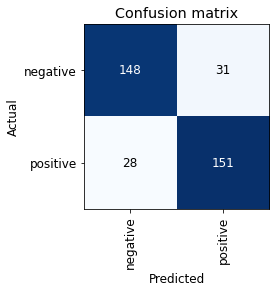

In [36]:
interp.plot_confusion_matrix()

In [19]:
learn.show_results()

,text,category,category_
0,"xxbos xxup st . xxup petersburg , xxmaj oct 14 ( xxup prime - xxunk ) -- xxmaj finnish xxunk producer xxmaj nokian xxmaj tyres plans to invest about 50 million euros in the expansion of its xxunk plant in the city of xxmaj xxunk in xxmaj russia 's xxmaj xxunk xxmaj region in 2011 , the company 's xxmaj president xxmaj xxunk xxmaj xxunk told xxunk xxmaj thursday .",positive,positive
1,"xxbos xxup kauko - telko xxup ltd xxup press xxup release xxunk xxup at xxunk 1 ( 1 ) xxmaj telko xxmaj group ( kauko - telko ) is expanding its strategic partnership with xxup bp xxmaj industrial xxmaj xxunk & xxmaj services ( xxup bp xxup xxunk ) by acquiring total xxunk of xxup bp 's xxmaj swedish retail company , xxunk - xxunk xxup ab .",positive,positive
2,"xxbos xxmaj xxunk xxmaj third xxmaj xxunk xxmaj logistics xxmaj leader xxmaj xxunk for best - in - xxunk xxmaj technology , xxmaj xxunk xxmaj capabilities ; xxmaj leading xxmaj specialty xxmaj packaging xxmaj manufacturer xxmaj employs xxmaj complete xxunk xxmaj solution for xxmaj supply xxmaj chain xxmaj xxunk and xxmaj transportation xxmaj efficiency to xxmaj increase xxmaj service xxmaj levels and on - time xxmaj deliveries",positive,positive
3,"xxbos xxmaj rapala xxup vmc xxmaj corporation xxup stock xxup exchange xxup release xxmaj october 10 , 2008 at xxunk am xxmaj kaupthing xxmaj bank xxmaj oyj ( ` ` xxmaj xxunk '' ) has xxunk xxmaj rapala xxup vmc xxmaj corporation ( ` ` xxmaj rapala '' ) that it has xxunk the liquidity providing for xxmaj rapala 's share for the time being .",negative,positive
4,"xxbos xxup adp xxmaj news - xxmaj xxunk 22 , 2009 - xxmaj finnish business information systems developer xxmaj solteq xxmaj oyj xxup hel : xxup xxunk said today its net loss widened to xxup eur xxunk , xxrep 3 0 xxup usd xxunk , xxrep 3 0 for the first quarter of 2009 from xxup eur 10 , xxrep 3 0 for the same xxunk",negative,positive
5,"xxbos ( xxup adp xxmaj news ) - xxmaj oct 31 , 2008 - xxmaj finnish food company xxmaj raisio xxmaj oyj ( xxup omx : xxup xxunk ) said today that its net profit jumped to xxup eur 16.4 million ( xxup usd xxunk m ) for the first nine months of 2008 from xxup eur 1.1 million for the same period of 2",positive,positive
6,xxbos xxup xxunk xxmaj april xxunk xxmaj group xxmaj plc xxunk stake in xxmaj morning xxmaj digital xxmaj design xxmaj oy xxmaj finnish xxup it company xxup xxunk xxmaj group xxmaj plc said on xxmaj friday 7 xxmaj april that it had signed an agreement on selling its shares of xxmaj morning xxmaj digital xxmaj design xxmaj oy to xxmaj xxunk xxmaj oyj .,positive,positive
7,xxbos xxmaj the xxunk that was xxunk route from the xxmaj finnish port of xxmaj turku to xxmaj stockholm xxunk xxunk in ice already around 4 xxunk on xxmaj wednesday and the xxmaj xxunk xxmaj star 's xxunk from the xxmaj swedish port of xxmaj xxunk to xxmaj xxunk in xxunk xxmaj estonia was cut short at 2 a.m. on xxmaj thursday .,negative,negative
8,"xxbos ( adpnews ) - xxmaj oct 21 , 2009 - xxmaj finland - based xxup it consultancy xxmaj tieto xxmaj oyj ( xxup hel : xxup xxunk ) said today its net profit xxunk to xxup eur xxunk million ( xxup usd xxunk m ) for the first nine months of 2009 from xxup eur xxunk million for the same period xxunk",negative,positive
